In [3]:
%matplotlib notebook
%matplotlib inline

In [2]:
# importing necessary libraries for the 'Water Allocation Price Prediction model development project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
# reading the water market transactions data for Goulburn
data_Murray_Goulburn_Murray = pd.read_csv('data_Murray_Goulburn_Murray.csv')

In [5]:
# displaying the data
data_Murray_Goulburn_Murray

,Total Traded Volume (ML),Volume Weighted Average Price ($),Date
0,120.0,2610.816667,2009-05-01
1,2806.6,672.739543,2009-06-01
2,18812.9,2227.445579,2009-07-01
3,1290.2,2265.075947,2009-08-01
4,240.3,2318.435289,2009-09-01
...,...,...,...
175,595.0,4699.613445,2023-12-01
176,577.5,5918.474405,2024-01-01
177,1080.6,1951.919304,2024-02-01
178,714.4,4044.883819,2024-03-01


In [6]:
# converting the setting the 'Data' column to the 'datetime' format 
data_Murray_Goulburn_Murray["Date"] = pd.to_datetime(data_Murray_Goulburn_Murray["Date"], format = '%Y/%m/%d')

# modifying the current datetime format of the 'Date' and formatting it separately as years and months
data_Murray_Goulburn_Murray["Year"] = data_Murray_Goulburn_Murray["Date"].dt.year
data_Murray_Goulburn_Murray["Month"] = data_Murray_Goulburn_Murray["Date"].dt.month

# extracting processed transaction data only for months of June (6), July (7), and August (8)
data_Murray_Goulburn_Murray_season_3 = data_Murray_Goulburn_Murray[data_Murray_Goulburn_Murray["Month"].between(6, 8)]

# removing the previous date information from the new dataset after creating a new date feature
data_Murray_Goulburn_Murray = data_Murray_Goulburn_Murray.drop(['Year'], axis = 1)
data_Murray_Goulburn_Murray = data_Murray_Goulburn_Murray.drop(['Month'], axis = 1)

data_Murray_Goulburn_Murray_season_3 = data_Murray_Goulburn_Murray_season_3.drop(['Year'], axis = 1)
data_Murray_Goulburn_Murray_season_3 = data_Murray_Goulburn_Murray_season_3.drop(['Month'], axis = 1)

In [7]:
# setting the date feature of the dataset as an index
data_Murray_Goulburn_Murray.set_index('Date', inplace = True)

# setting the date feature of the dataset as an index
data_Murray_Goulburn_Murray_season_3.set_index('Date', inplace = True)

In [8]:
# displaying the data
data_Murray_Goulburn_Murray

,Total Traded Volume (ML),Volume Weighted Average Price ($)
Date,,
2009-05-01,120.0,2610.816667
2009-06-01,2806.6,672.739543
2009-07-01,18812.9,2227.445579
2009-08-01,1290.2,2265.075947
2009-09-01,240.3,2318.435289
...,...,...
2023-12-01,595.0,4699.613445
2024-01-01,577.5,5918.474405
2024-02-01,1080.6,1951.919304


In [9]:
# displaying the data
data_Murray_Goulburn_Murray_season_3.head()

,Total Traded Volume (ML),Volume Weighted Average Price ($)
Date,,
2009-06-01,2806.6,672.739543
2009-07-01,18812.9,2227.445579
2009-08-01,1290.2,2265.075947
2010-06-01,5793.9,2201.404923
2010-07-01,6024.5,2072.838543


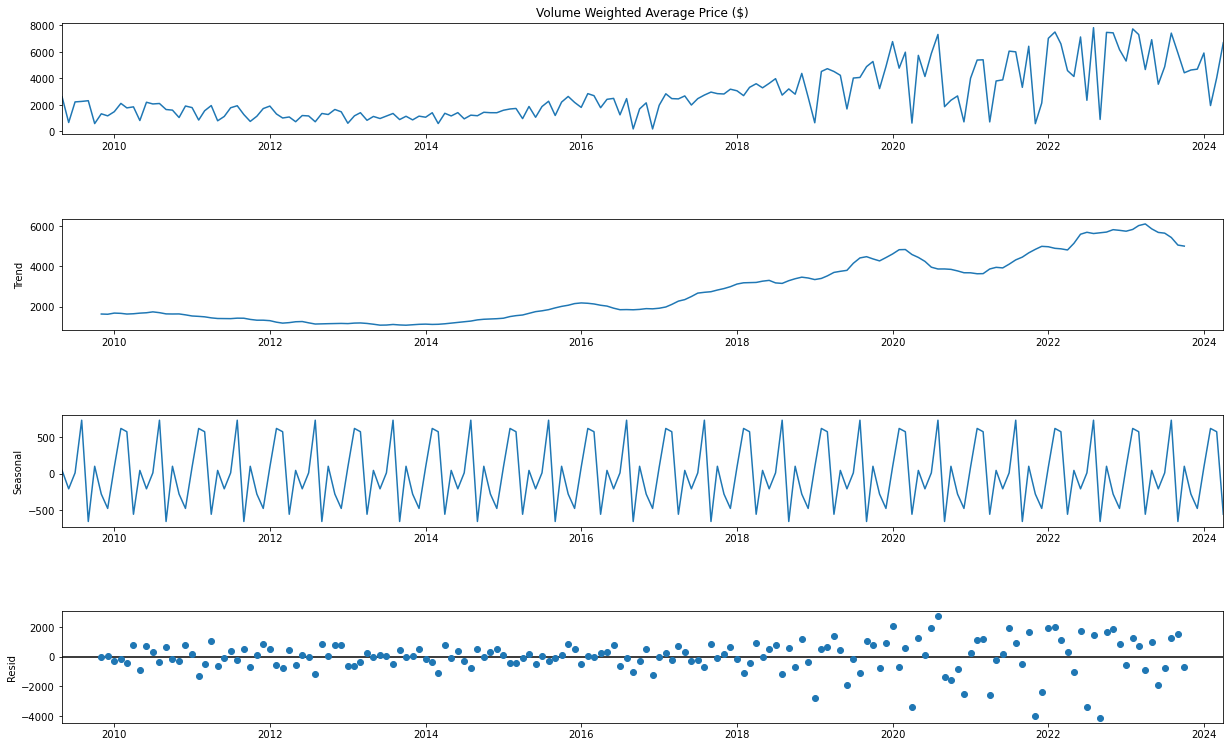

In [11]:
# decomposing the 'Volume Weighted Average Price' column of the dataset for analysis of its features
trend_decomposition = seasonal_decompose(data_Murray_Goulburn_Murray["Volume Weighted Average Price ($)"], model = 'additive')

# creating a figure and plotting the features
figure = trend_decomposition.plot()
figure.set_size_inches((20, 12))

figure.savefig('Decomposition of Price Time Series Data.png', dpi = 300)

In [10]:
# extracting volume weighted average price data from the dataset 
price_data = data_Murray_Goulburn_Murray['Volume Weighted Average Price ($)']

# dividing the price data into training and testing datasets
train_data, test_data = train_test_split(price_data, test_size = 0.2, shuffle = True)

# displaying information about shapes of training and testing datasets
train_data.shape, test_data.shape

((144,), (36,))

In [11]:
# extracting linear trend parameter from the time series
linear_trend = sts.LocalLinearTrend(observed_time_series = np.array(train_data))

# extracting seasonal parameter from the time series
seasonal_trend = sts.Seasonal(num_seasons = 12, observed_time_series = np.array(train_data), allow_drift = True)

# creating structural model by combining the linear and seasonal trends together
model = sts.Sum([linear_trend, seasonal_trend], observed_time_series = np.array(train_data))

Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [12]:
# fitting the model to the data and building a posterior predictive distribution using Variational Inference
variational_posteriors = sts.build_factored_surrogate_posterior(model = model)

# fitting a set of approximate posterior distributions for the model parameters
# defined for each component and optimising these by minimising
# a variational loss function known as negative Evidence Lower Bound

elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn = model.joint_log_prob(observed_time_series = np.array(train_data)),
    surrogate_posterior = variational_posteriors,
    optimizer = tf.optimizers.Adam(learning_rate = 0.1),
    num_steps = 200
)

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Text(0.5, 1.0, 'Elbo Loss Curve')

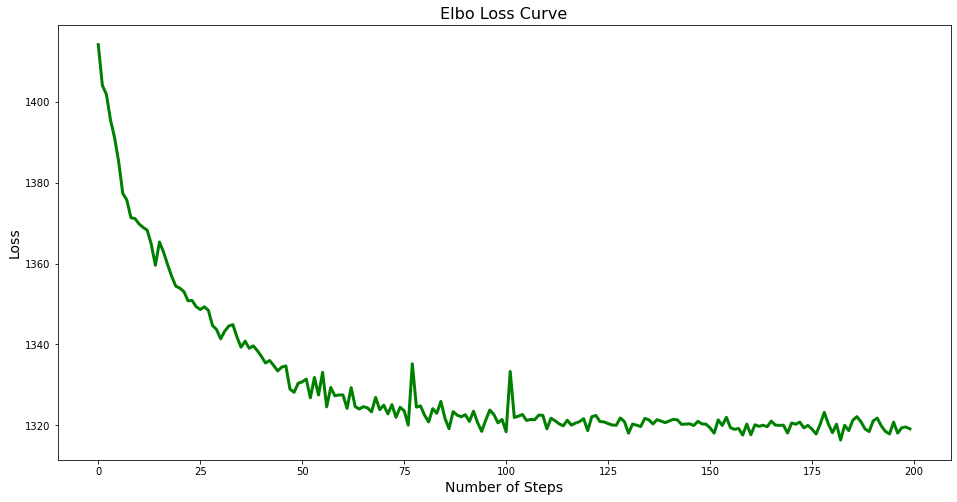

In [13]:
# creating a figure and plotting the loss curve
plt.figure(figsize = (16, 8))

plt.plot(elbo_loss_curve, color = 'green', linewidth = 3)

plt.xlabel('Number of Steps', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
plt.title('Elbo Loss Curve', fontsize = 16)

In [14]:
# drawing traces from posterior
posterior_samples = variational_posteriors.sample(50)

# number of timesteps to forecast
n_forecast_steps = len(np.array(test_data))

# building forecast distribution over future timesteps 
model_forecast_distr = sts.forecast(
    model,
    observed_time_series = np.array(test_data),
    parameter_samples = posterior_samples,
    num_steps_forecast = n_forecast_steps)

# drawing samples for forecasting
samples = 50

# assigning variables corresponding to variational posterior
forecast_mean = model_forecast_distr.mean().numpy()[..., 0]
forecast_std = model_forecast_distr.stddev().numpy()[..., 0]
forecast_samples = model_forecast_distr.sample(samples).numpy()[..., 0]

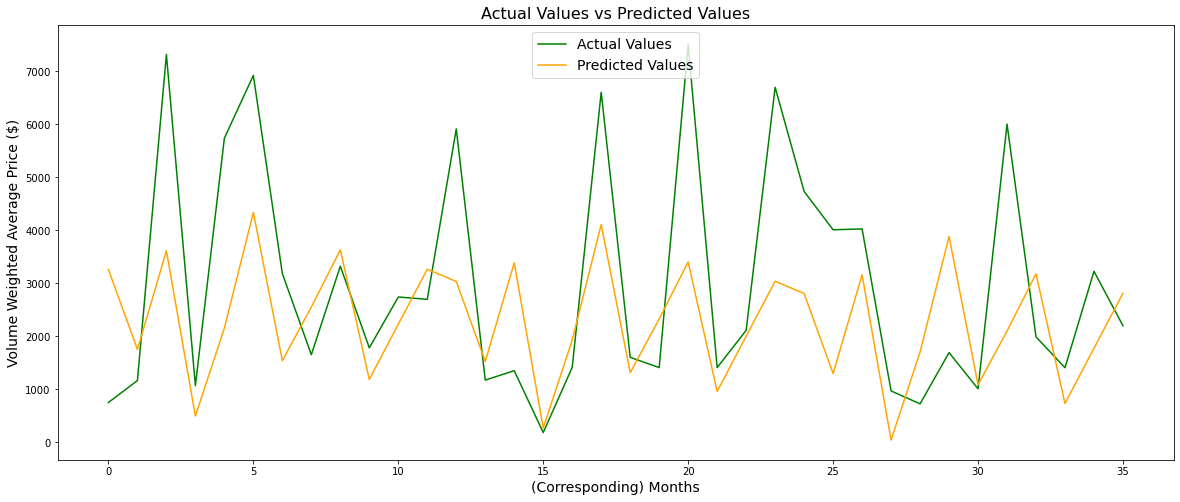

In [24]:
# creating a figure
plt.figure(figsize = (20, 8))

# plotting actual values and predicted values
plt.plot(np.array(test_data), color = 'green', label = "Actual Values")
plt.plot(forecast_mean, color = 'orange', label = "Predicted Values")

# labeling and naming the figure
plt.xlabel('(Corresponding) Months', fontsize = 14)
plt.ylabel('Volume Weighted Average Price ($)', fontsize = 14)
plt.title('Actual Values vs Predicted Values', fontsize = 16)

# putting a legend into the figure
plt.legend(loc = 'upper center', fontsize = 14)

# saving the figure
plt.savefig("Time Series Prediction via Tensorflow Structural Modelling.png", dpi = 300)